# Import data

In [1]:
import pandas as pd

data = pd.read_csv("../single_parameter/combined_data/statistics.csv")
data.head()

,RunId,TargetModule,Algorithm,AlgorithmIterations,SearchTime,TuningParameters,Coverage,CoverageTimeline_T1,CoverageTimeline_T2,CoverageTimeline_T3,...,CoverageTimeline_T291,CoverageTimeline_T292,CoverageTimeline_T293,CoverageTimeline_T294,CoverageTimeline_T295,CoverageTimeline_T296,CoverageTimeline_T297,CoverageTimeline_T298,CoverageTimeline_T299,CoverageTimeline_T300
0,flutils.decorators#247,flutils.decorators,DYNAMOSA_RL,1513,300064136954,TestChangeProbability,0.666667,0.666667,0.666667,0.666667,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
1,codetiming._timer#100,codetiming._timer,DYNAMOSA_RL,1001,300064143210,Elite,0.888889,0.555556,0.555556,0.629630,...,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889
2,codetiming._timer#222,codetiming._timer,DYNAMOSA_RL,1516,300085846117,StatementInsertionProbability,0.888889,0.444444,0.666667,0.696566,...,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889
3,flutils.decorators#327,flutils.decorators,DYNAMOSA_RL,1510,300133832198,TestInsertProbability,0.666667,0.666667,0.666667,0.666667,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
4,httpie.output.formatters.headers#50,httpie.output.formatters.headers,DYNAMOSA_RL,2089,300206714135,ChromosomeLength,0.600000,0.600000,0.600000,0.600000,...,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000


# Coverage Distribution plot

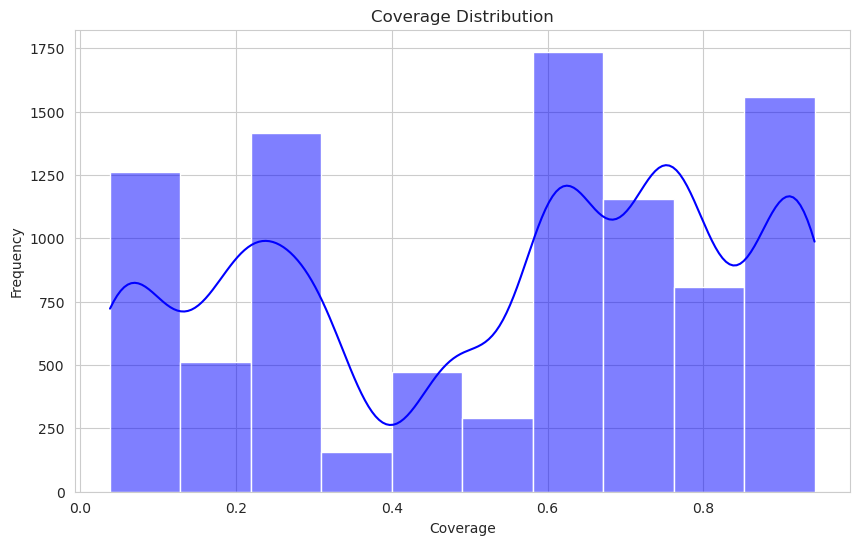

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb

# Style
sb.set_style('whitegrid')

plt.figure(figsize=(10,6))
sb.histplot(data['Coverage'], bins=10, kde=True, color='blue')
plt.title('Coverage Distribution')
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.show()

# Data preperation

In [28]:
import pymc
import formulaic
import pandas as pd
import numpy as np

model_formula = 'Coverage ~ C(TargetModule) * C(TuningParameters, Treatment(reference="NONE"))'
model_spec = formulaic.model_matrix(model_formula, data=data)

y = model_spec.lhs
x = model_spec.rhs

In [34]:
with pymc.Model() as model:
    # Priors
    coefs = pymc.Normal('coefs', mu=0, sigma=10, shape=(x.shape[1],))  # One coefficient per predictor
    phi = pymc.Gamma('phi', alpha=2, beta=0.5)  # Precision of the Beta distribution

    # Expected value of outcome
    eta = pymc.math.dot(x, coefs)  # Linear combination of predictors and coefficients
    mu = pymc.math.sigmoid(eta)  # Link function, logistic

    # Likelihood
    Y_obs = pymc.Beta('Y_obs', alpha=mu * phi, beta=(1 - mu) * phi, observed=y['Coverage'])

    # Posterior sampling
    trace = pymc.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [coefs, phi]


/home/henrik/miniconda3/envs/analysis_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 861 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [35]:
import arviz as az
# Summarize the model outputs

summary = az.summary(trace) #pymc.summary(trace)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefs[0],1.933,0.063,1.814,2.039,0.014,0.010,20.0,39.0,1.12
coefs[1],-1.261,0.088,-1.420,-1.090,0.016,0.011,32.0,63.0,1.06
coefs[2],0.701,0.123,0.479,0.948,0.018,0.013,46.0,149.0,1.06
coefs[3],-4.746,0.124,-4.978,-4.513,0.015,0.011,66.0,129.0,1.04
coefs[4],-4.430,0.117,-4.648,-4.223,0.019,0.014,37.0,117.0,1.06
...,...,...,...,...,...,...,...,...,...
coefs[308],-0.096,0.143,-0.373,0.167,0.021,0.015,48.0,78.0,1.05
coefs[309],-0.055,0.146,-0.327,0.213,0.021,0.015,50.0,268.0,1.05
coefs[310],-0.053,0.138,-0.307,0.206,0.023,0.016,37.0,114.0,1.06
coefs[311],-0.213,0.136,-0.459,0.042,0.019,0.014,50.0,86.0,1.03


array([[<Axes: title={'center': 'coefs'}>,
        <Axes: title={'center': 'coefs'}>],
       [<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>]],
      dtype=object)

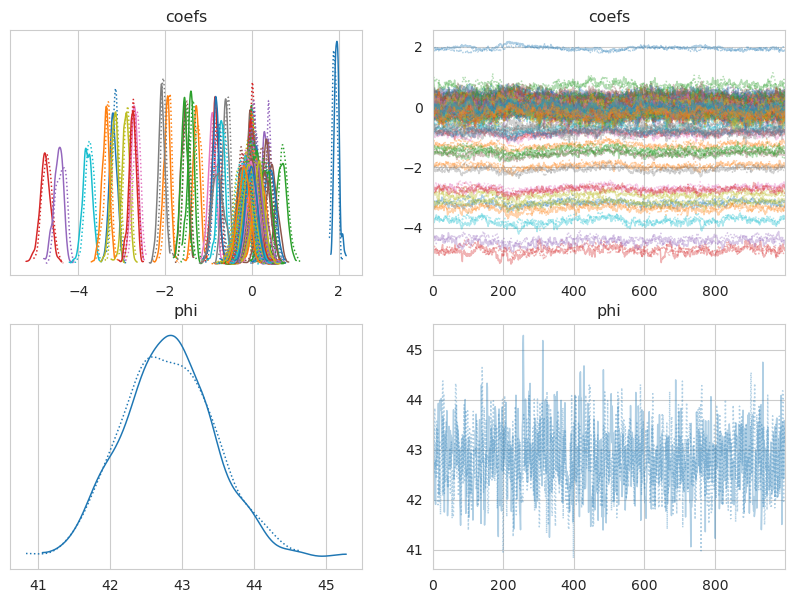

In [36]:
az.plot_trace(trace, figsize=(10, 7))